### こっちは変えても良い

In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
# setting learning schedul
from torch.optim.lr_scheduler import LambdaLR
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

### 自由点が(0.5, 0.4330)になればすべての三角形が正三角形になるような六角形とその中の自由点を設定

mesh_data: {'vertices': tensor([[0.2500, 0.0000],
        [0.7500, 0.0000],
        [1.0000, 0.4330],
        [0.7500, 0.8660],
        [0.2500, 0.8660],
        [0.0000, 0.4330],
        [0.4879, 0.4487]], dtype=torch.float64), 'faces': tensor([[0, 1, 6],
        [1, 2, 6],
        [2, 3, 6],
        [3, 4, 6],
        [4, 5, 6],
        [5, 0, 6]])}


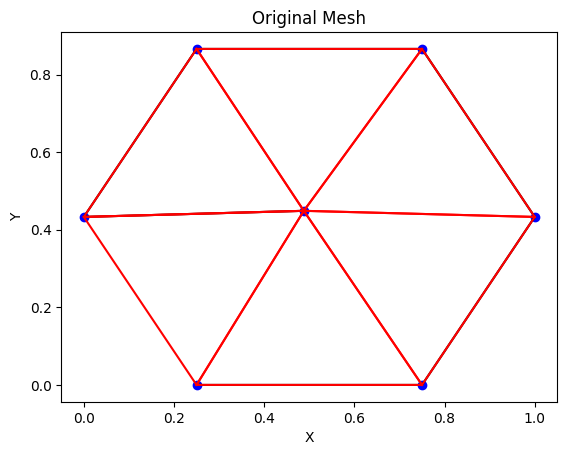

In [123]:
def create_data():
    random_number_x = random.random()
    random_number_y = random.random()
    root_3 = torch.sqrt(torch.tensor(3.))
    vertices = torch.tensor([[0.25, 0], [0.75, 0], [1, 0.25*root_3], [0.75, 0.5*root_3], [0.25, 0.5*root_3], [0, 0.25*root_3], [random_number_x, random_number_y]], dtype=torch.float64)
    faces = torch.tensor([[0, 1, 6], [1, 2, 6], [2, 3, 6], [3, 4, 6], [4, 5, 6], [5, 0, 6]])
    mesh_data = {
        "vertices": vertices,
        "faces": faces
    }
    # print(mesh_data)
    return mesh_data

def plot_mesh(vertices, faces, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # 描画するメッシュの頂点をプロット
    ax.plot(vertices[:,0], vertices[:,1], 'bo')  # 頂点を青色の点でプロット
    ax.plot(vertices[:,0], vertices[:,1], 'k-')  # 辺を黒色の線でプロット

    # 各三角形をプロット
    for face in faces:
        v0, v1, v2 = vertices[face]
        ax.plot([v0[0], v1[0], v2[0], v0[0]], [v0[1], v1[1], v2[1], v0[1]], 'r-')  # 三角形を赤色の線でプロット

    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')

    plt.show()

mesh_data = create_data()
print("mesh_data:", mesh_data)
# オリジナルのメッシュをプロット
plot_mesh(mesh_data["vertices"], mesh_data["faces"], title="Original Mesh")

### 中間層をGCNにしてみる

In [124]:
class MeshSmoothingNN(nn.Module):
    def __init__(self, input_size):
        super(MeshSmoothingNN, self).__init__()
        torch.manual_seed(42)
        self.fc1 = nn.Linear(input_size, 2*input_size)
        self.fc2 = nn.Linear(2*input_size, input_size)
        self.sig = nn.Sigmoid()

    

    def forward(self, x):
        x = self.sig(self.fc1(x))
        x = self.sig(self.fc2(x))

        return x

model = MeshSmoothingNN(input_size=2).double()  # 倍精度にする
print(model)

num_iterations = 10
optimizer = torch.optim.SGD(model.parameters(), momentum=0.9,lr=0.01)
cosine_dacay = lambda iteration: 0.01 * (1 + math.cos(math.pi * iteration / num_iterations)) / 2
scheduler = LambdaLR(optimizer, lr_lambda=cosine_dacay)
criterion = torch.nn.MSELoss()


MeshSmoothingNN(
  (fc1): Linear(in_features=2, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=2, bias=True)
  (sig): Sigmoid()
)


# q を求めるための関数を定義

In [125]:
def select_vertices(vertices, face):
    v0 = vertices[face[0]]
    v1 = vertices[face[1]]
    v2 = vertices[face[2]]
    return v0, v1, v2 

def edge_length(v0, v1, v2):
    l1 = torch.sqrt((v0[0] - v1[0])**2 + (v0[1] - v1[1])**2)
    l2 = torch.sqrt((v1[0] - v2[0])**2 + (v1[1] - v2[1])**2)
    l3 = torch.sqrt((v2[0] - v0[0])**2 + (v2[1] - v0[1])**2)

    return l1, l2, l3

def face_area(l1, l2, l3):
    s = (l1 + l2 + l3)/2
    face_area = torch.sqrt(s*(s-l1)*(s-l2)*(s-l3))
    return face_area

def compute_q(vertices, face):
    v0, v1, v2 = select_vertices(vertices, face)
    l1, l2, l3 = edge_length(v0, v1, v2)
    s = face_area(l1, l2, l3)

    q = (l1**2 + l2**2 + l3**2)/(4.0*torch.sqrt(torch.tensor(3.))*s)
    q = torch.tensor(q, dtype=torch.float64)
    return q

def train(vertices, faces):
    model.train()

    vertices_input = torch.tensor(vertices, dtype=torch.float64, requires_grad=True)

    for _ in range(num_iterations):
        # print("vertices:", vertices)
        out = model(vertices_input)
        free_point = torch.mean(out, dim=0)
        vertices[-1] = free_point
        # print("vertices:", vertices[6])
        q_list = []
        target_list = []
        for face in faces:
            q = compute_q(vertices, face)
            q_list.append(q)
            target = torch.tensor(1, dtype=torch.float64)
            target_list.append(target)
            del q, target
        q_tensor = torch.tensor(q_list, dtype=torch.float64, requires_grad=True)
        target_tensor = torch.tensor(target_list, dtype=torch.float64, requires_grad=True)
        # print("q_tensor:", q_tensor)
        # print("target_tensor:", target_tensor)
        loss = criterion(q_tensor.squeeze(), target_tensor)
        del q_tensor, target_tensor
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        print("free_point:",free_point)
        print("loss:", loss)
        vertices_input = vertices.detach().clone()
        print()

def test(vertices, faces):
    print("vertices:", vertices)
    out = model(vertices)
    free_point = torch.mean(out, dim=0)
    # print("free_point:",free_point)
    vertices[-1] = free_point.unsqueeze(0)  
    print("vertices:", vertices)
    smoothed_mesh_data = {
        "vertices": vertices.clone().detach().numpy(),
        "faces": faces
    }

    plot_mesh(smoothed_mesh_data["vertices"], smoothed_mesh_data["faces"], title="Smoothed Mesh")



free_point: tensor([0.5487, 0.5452], dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(0.0018, dtype=torch.float64, grad_fn=<MseLossBackward0>)

free_point: tensor([0.5489, 0.5455], dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(0.0018, dtype=torch.float64, grad_fn=<MseLossBackward0>)

free_point: tensor([0.5489, 0.5455], dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(0.0018, dtype=torch.float64, grad_fn=<MseLossBackward0>)

free_point: tensor([0.5489, 0.5455], dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(0.0018, dtype=torch.float64, grad_fn=<MseLossBackward0>)

free_point: tensor([0.5489, 0.5455], dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(0.0018, dtype=torch.float64, grad_fn=<MseLossBackward0>)

free_point: tensor([0.5489, 0.5455], dtype=torch.float64, grad_fn=<MeanBackward1>)
loss: tensor(0.0018, dtype=torch.float64, grad_fn=<MseLossBackward0>)

free_point: tensor([0.5489, 0.5455], dtype=torch.float64, grad_fn=<MeanBackw

/tmp/ipykernel_261980/332275697.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vertices_input = torch.tensor(vertices, dtype=torch.float64, requires_grad=True)
/tmp/ipykernel_261980/332275697.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(q, dtype=torch.float64)


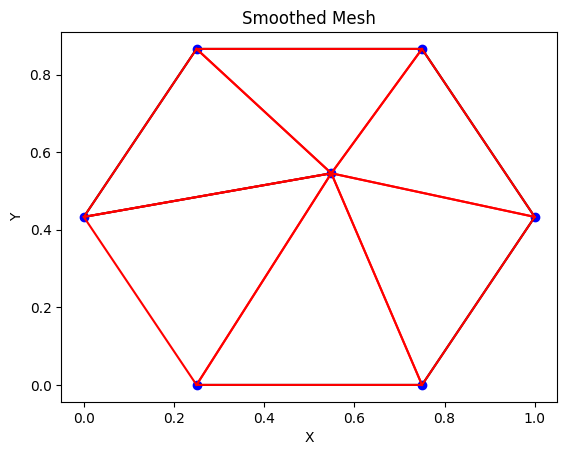

In [126]:
# for epoch in range(10):
train(mesh_data["vertices"], mesh_data["faces"])
test(mesh_data["vertices"], mesh_data["faces"])

### rescaling

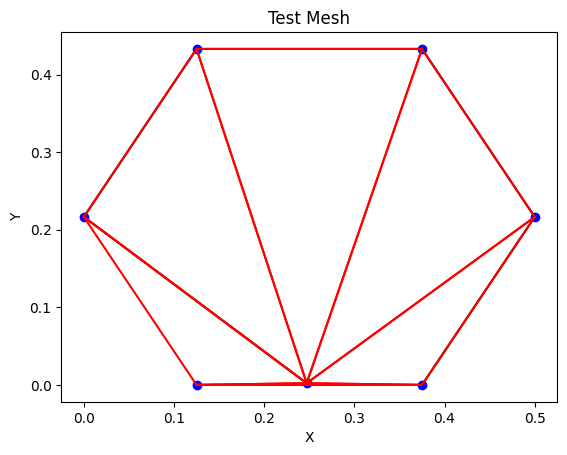

vertices: tensor([[0.1250, 0.0000],
        [0.3750, 0.0000],
        [0.5000, 0.2165],
        [0.3750, 0.4330],
        [0.1250, 0.4330],
        [0.0000, 0.2165],
        [0.2471, 0.0022]], dtype=torch.float64)
vertices: tensor([[0.1250, 0.0000],
        [0.3750, 0.0000],
        [0.5000, 0.2165],
        [0.3750, 0.4330],
        [0.1250, 0.4330],
        [0.0000, 0.2165],
        [0.5435, 0.5395]], dtype=torch.float64, grad_fn=<CopySlices>)


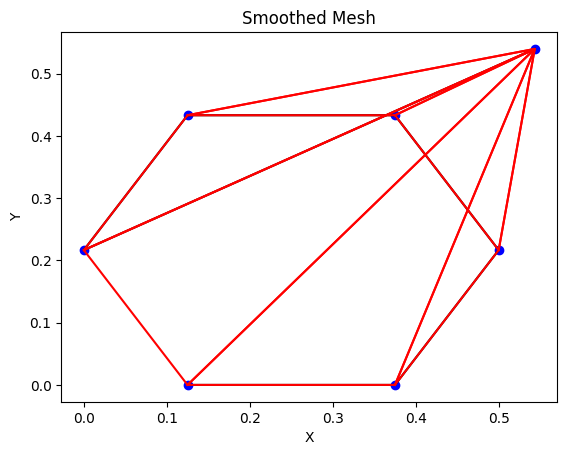

In [127]:
test_mesh_data = create_data()
test_mesh_data["vertices"] = test_mesh_data["vertices"] * 0.5
plot_mesh(test_mesh_data["vertices"], test_mesh_data["faces"], title="Test Mesh")
# print("test_mesh_data:", test_mesh_data)
test(test_mesh_data["vertices"], test_mesh_data["faces"])